In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In this notebook, we use a pre-trained convolutional neural network (CNN) to extract features from labeled images. Specifically, we use the VGG-16 model trained on the ImageNet dataset to extract features from the CIFAR-10 dataset. Then, we use linear discriminant analysis (LDA) and t-distributed stochastic neighbor embedding (t-SNE) to visualize the extracted features. Finally, we use the extracted features to train a Gradient Boosting Decision Trees (GBDT) classifier.

# Dataset

In this notebook, we will use CIFAR-10. We chose CIFAR-10 because it is small. The smallness will speed up the VGG-16 and t-SNE calculations.

CIFAR-10 is a set of 60,000 images. CIFAR-10 comprises 4 subsets. Each subset is a NumPy array of unsigned 8-bit integers. The `x_train` and `x_test` subsets are the images. Each image comprises 32x32 pixels. Each pixel comprises a red, green, and blue value. Alternatively, each image comprises a red, green, and blue channel. Each channel comprises 32x32 values. Each value ranges from 0-255. The `y_train` and `y_test` subsets are the labels. Each label comprises a value. Each value ranges from 0-9. Each value corresponds to a class. The `x_train` subset is associated with the `y_train` subset. The `x_test` subset is associated with the `y_test` subset ([CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), [Keras](https://keras.io/api/datasets/cifar10/)).

In [ ]:
# Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

labels = ('plane', 'car', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck')

# Show data
print(f'x_train = ndarray(shape={x_train.shape}, dtype={x_train.dtype})')
print(f'y_train = ndarray(shape={y_train.shape}, dtype={y_train.dtype})\n')

print(f'x_test = ndarray(shape={x_test.shape}, dtype={x_test.dtype})')
print(f'y_test = ndarray(shape={y_test.shape}, dtype={y_test.dtype})\n')

print(f'labels = {labels}')

x_train = ndarray(shape=(50000, 32, 32, 3), dtype=uint8)
y_train = ndarray(shape=(50000, 1), dtype=uint8)

x_test = ndarray(shape=(10000, 32, 32, 3), dtype=uint8)
y_test = ndarray(shape=(10000, 1), dtype=uint8)

labels = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


The following figure shows 5 sample images from each class.

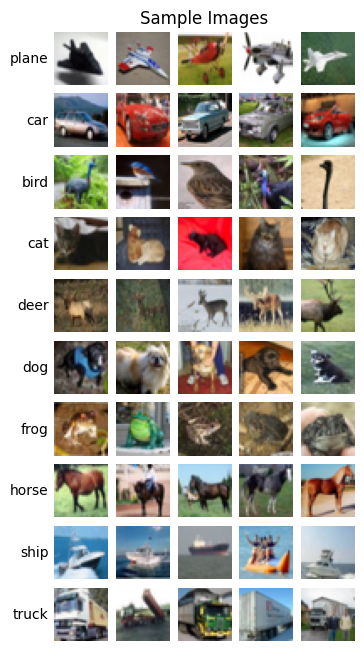

In [ ]:
# Create figure
fig, ax = plt.subplots(10, 5, figsize=(4.8, 6.4), layout='compressed')
ax[0, 2].set_title('Sample Images')

# Plot samples
for i, label in enumerate(labels):
    ax[i, 0].set_ylabel(label, rotation=0, ha='right', va='center')
    xi = (x for x, y in zip(x_train, y_train) if y == i)
    for j in range(5):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_frame_on(False)
        ax[i, j].imshow(next(xi))
plt.show()

# Free memory
del fig, ax, i, label, xi, j

# Preprocessing

In this notebook, we will use VGG-16 pre-trained on ImageNet. We chose VGG-16 because it is simple.

VGG-16 is a CNN with 16 trainable layers. VGG-16 comprises 6 blocks. Each of the first two blocks comprise 2 convolutional layers and 1 pooling layer. Each of the next three blocks comprise 3 convolutional layers and 1 pooling layer. The top block comprises 3 dense layers ([VGG-16](https://arxiv.org/abs/1409.1556), [Keras](https://keras.io/api/applications/vgg/)).

For feature extraction, we will use the top pooling layer. We chose the top pooling layer because it has the smallest dimensionality. The smallness will speed up the t-SNE calculations.

In [ ]:
# Create VGG16
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

Before feature extraction, we will convert each image from RGB to BGR, and center each image with respect to ImageNet ([Keras](https://keras.io/api/applications/vgg/)).

In [ ]:
# Preprocess train
x_train = preprocess_input(x_train)
x_train = vgg16.predict(x_train, verbose=0)
x_train = np.squeeze(x_train)
y_train = np.squeeze(y_train)

# Show train
print(f'x_train = ndarray(shape={x_train.shape}, dtype={x_train.dtype})')
print(f'y_train = ndarray(shape={y_train.shape}, dtype={y_train.dtype})')

x_train = ndarray(shape=(50000, 512), dtype=float32)
y_train = ndarray(shape=(50000,), dtype=uint8)


# Visualization

To measure the variance of the extracted features, we will calculate the ratio of the between-class sum of squares to the within-class sum of squares. A ratio close to zero denotes poor class separability.

In [ ]:
# Calculate ratio
w, b = 0, 0
x_ = np.mean(x_train, axis=0)
for i in range(10):
    xi = x_train[y_train == i]
    xi_ = np.mean(xi, axis=0)
    for xij in xi:
        w += np.sum((xij - xi_) ** 2)
    b += len(xi) * np.sum((xi_ - x_) ** 2)
variance_ratio = b / w

# Show ratio
print(f'variance_ratio = {variance_ratio:.2e}')

# Free memory
del w, b, x_, i, xi, xi_, xij

variance_ratio = 8.68e-02


To visualize the extracted features, we will use t-SNE. t-SNE is a dimensionality reduction technique that preserves the pairwise distances between observations ([t-SNE](https://lvdmaaten.github.io/tsne/), [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)). Before t-SNE, we will use LDA. LDA is dimensionality technique that maximizes the ratio of the between-class scatter matrix to the within-class scatter-matrix ([scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)). We chose LDA to speed up the t-SNE calculations.

The following figure shows 500 samples from each class. In the figure, the cat and dog, car and truck, and plane and ship classes overlap.

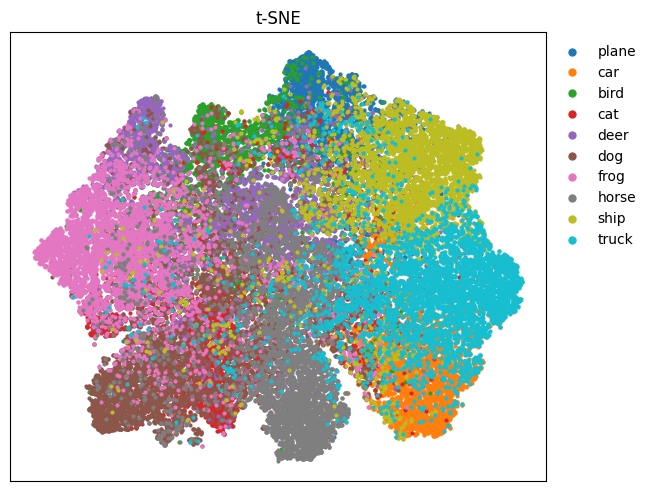

In [ ]:
# Do LDA
lda = LinearDiscriminantAnalysis()
x_lda = lda.fit_transform(x_train, y_train)

# Do t-SNE
tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(x_lda)

# Create figure
fig, ax = plt.subplots(layout='compressed')

# Plot t-SNE
for i, label in enumerate(labels):
    xi, yi = x_tsne[y_train == i].T
    ax.scatter(xi, yi, s=4, label=label)
ax.legend(bbox_to_anchor=(1, 1), frameon=False, markerscale=2.5)
ax.set_title('t-SNE')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# Free memory
del fig, ax, i, label, xi, yi

# Modeling

Next, we will use the extracted features to train a GBDT classifier. A GBDT classifier is a "strong model." The strong model comprises many "weak models." Each weak model is a decision tree. During training, we train a weak model to predict the error of the strong model. Then, we append the weak model to the strong model ([Gradient Boosting](https://www.sciencedirect.com/science/article/pii/S0167947301000652), [GBDT](https://developers.google.com/machine-learning/decision-forests/intro-to-gbdt), [XGBoost](https://xgboost.readthedocs.io/en/stable/tutorials/model.html)).

In [ ]:
# Train GBDT
gbdt = XGBClassifier()
gbdt.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Before testing, we will apply the same preprocessing steps from the `x_train` and `y_train` subsets to the `x_test` and `y_test` subsets.

In [ ]:
# Preprocess test
x_test = preprocess_input(x_test)
x_test = vgg16.predict(x_test, verbose=0)
x_test = np.squeeze(x_test)
y_test = np.squeeze(y_test)

# Show test
print(f'x_test = ndarray(shape={x_test.shape}, dtype={x_test.dtype})')
print(f'y_test = ndarray(shape={y_test.shape}, dtype={y_test.dtype})')

x_test = ndarray(shape=(10000, 512), dtype=float32)
y_test = ndarray(shape=(10000,), dtype=uint8)


Finally, we will use the trained GBDT to predict the `y_test` subset. The model has an accuracy of 67%. The model is best at predicting cars and ships, and worst at predicting cats.

In [ ]:
# Predict test
y_pred = gbdt.predict(x_test)

# Classification report
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

       plane       0.71      0.74      0.72      1000
         car       0.73      0.75      0.74      1000
        bird       0.63      0.56      0.59      1000
         cat       0.51      0.51      0.51      1000
        deer       0.62      0.61      0.62      1000
         dog       0.62      0.61      0.62      1000
        frog       0.68      0.74      0.71      1000
       horse       0.72      0.70      0.71      1000
        ship       0.74      0.77      0.75      1000
       truck       0.71      0.71      0.71      1000

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.67      0.67      0.67     10000



Additionally, the model often confuses the cat and dog, car and truck, and plane and ship classes. This result makes sense given the t-SNE visualization.

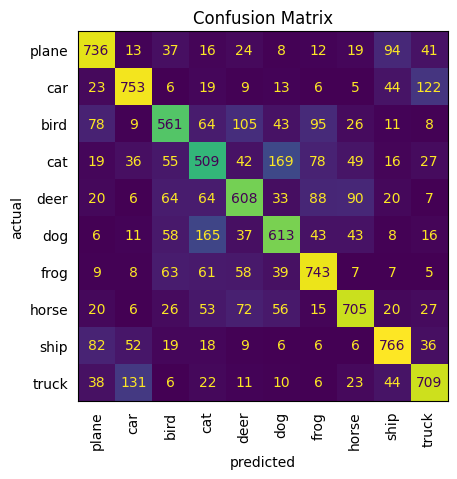

In [ ]:
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
    display_labels=labels, xticks_rotation='vertical', colorbar=False)
plt.title('Confusion Matrix')
plt.tick_params(left=False, bottom=False)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

# Conclusion

In this notebook, we used VGG-16 pre-trained on ImageNet to extract features from CIFAR-10. Then, we used LDA and t-SNE to visualize the extracted features. Finally, we used the extracted features to train a GBDT classifier. The GBDT classifier had an accuracy of 67%.

This is an example of a lightweight transfer-learning workflow. In a typical transfer-learning workflow, we would re-train the entire VGG16-GBDT model with a very low learning rate ([Keras](https://keras.io/guides/transfer_learning/)). Although this would improve the overall performance, it would also increase the overall train time.